In [307]:
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as F
import numpy as np
import albumentations

In [316]:
class Gridmask(DualTransform):
    """
    GridMask augmmentation Implementation using Albumentations

    Args:
        num_grid(int or list or tuple): number of grid in row or columns if list randomly choose on of the number to create mask
        fill_val(int): fill the grid with an integer
        rotate( (int, int) or int): range from which an angle is chosen to rotate the grid
        mode (int):
            0 - cropout a quater of square from each grid (left top)
            1 - reserve a quater of square from each grid (left top)
            2 - cropout 2 quater of square from each grid (left top & right bottom)
    Targets:
        image, mask
    Image types:
        uint8, float32
    
    """
    def __init__(self, num_grid = 3, fill_val = 0, rotate=0, mode = 0, always_apply=False, p=0.5):
        super(Gridmask, self).__init__(always_apply=always_apply, p=p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.rotate = rotate
        self.mode = mode
        self.fill_val = fill_val
        self.masks = None
        self.h_max = []
        self.w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            for n, n_g in enumerate(range( self.num_grid[0], self.num_grid[1]+1, 1 )):
                grid_height = height/n_g
                grid_width = width/n_g

                mask = np.zeros( (int( (n_g+1)*grid_height) , int( (n_g+1) * grid_width )) ).astype(np.uint8)
                for i in range(n_g+1):
                    for j in range(n_g+1):
                        mask[
                            int( i*grid_height ) : int( i*grid_height + grid_height/2 ),
                            int( j*grid_width ) : int( j*grid_width + grid_width/2 )    
                        ] = self.fill_val
                        
                        if self.mode == 2:
                            mask[
                                int( i * grid_height + grid_height/2 ):int( (i+1)* grid_height  ),
                                int( j * grid_width + grid_width/2 ):int( (j+1) * grid_width  )
                            ] = self.fill_val

                if self.mode == 1:
                    mask = self.fill_val - mask
                
                self.masks.append( mask )
                self.h_max.append( grid_height )
                self.w_max.append( grid_width )

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h,w = image.shape[:2]
        mask = F.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        # image = np.maximum( image, mask[rand_h : rand_h +h, rand_w: rand_w + w].astype(image.dtype) )
        bool_arr = np.random.randint(0,2, size=image.shape, dtype=bool)
        if self.mode != 1:
            for i in range(bool_arr.shape[2]):
                bool_arr[:,: ,i] = np.squeeze(mask[rand_h : rand_h +h, rand_w: rand_w + w] == self.fill_val )
        else:
            for i in range(bool_arr.shape[2]):
                bool_arr[:,: ,i] = np.squeeze(mask[rand_h : rand_h +h, rand_w: rand_w + w] == self.fill_val )
        image[bool_arr] = self.fill_val
        return image
    
    def get_params_dependent_on_targets(self, params):
        img = params["image"]
        height, width = img.shape[:2] 
        self.init_masks(height, width)
        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.h_max[mid])
        rand_w = np.random.randint(self.w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1]>0 else mask
        return { "mask": mask, "rand_h": rand_h, "rand_w": rand_w, "angle": angle }

    @property
    def targets_as_params(self):
        return ["image"]

    def get_transform_init_args_names(self):
        return ("num_grid", "fill_val", "rotate", "mode")


In [309]:
transforms = albumentations.Compose([
    Gridmask(num_grid = 3, fill_val=255.0, rotate=0, mode = 2, always_apply=True)
])

In [310]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread("./sample_image.jpg")
image = cv2.resize(image, (128, 128))

In [311]:
def show_image(image, name):
    image = image[:,:,::-1]
    plt.imshow(image)
    plt.title(name)
    plt.show()

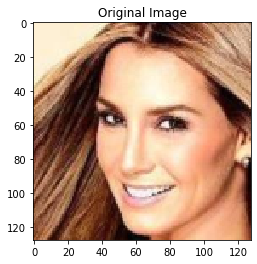

In [312]:
show_image(image, "Original Image")

(128, 128, 3)


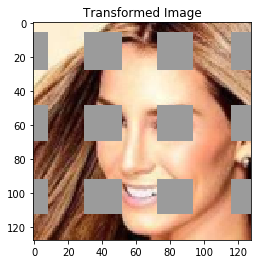

In [314]:
transforms = albumentations.Compose([
    Gridmask(num_grid = 3, fill_val=155.0, rotate=0, mode = 0, always_apply=True)
])
transformed_image = transforms(image=image.astype(np.uint8))
print(transformed_image["image"].shape)
show_image(transformed_image["image"], "Transformed Image")

(128, 128, 3)


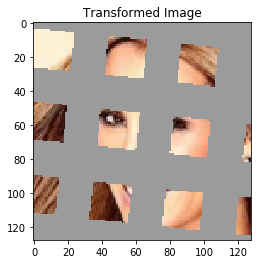

In [331]:
transforms = albumentations.Compose([
    Gridmask(num_grid = 3, fill_val=155.0, rotate=15, mode = 1, always_apply=True)
])
transformed_image = transforms(image=image.astype(np.uint8))
print(transformed_image["image"].shape)
show_image(transformed_image["image"], "Transformed Image")

(128, 128, 3)


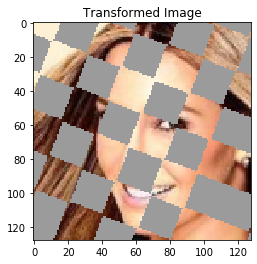

In [339]:
transforms = albumentations.Compose([
    Gridmask(num_grid = 3, fill_val=155.0, rotate=45, mode = 2, always_apply=True)
])
transformed_image = transforms(image=image.astype(np.uint8))
print(transformed_image["image"].shape)
show_image(transformed_image["image"], "Transformed Image")